In [1]:
import open3d as o3d

In [2]:
import numpy as np
import numpy.linalg as LA

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
import cv2

In [26]:
def transformation3(IM, transform_types='cartesian',fov_angle=94,fov_angle_o = None,no_data_indices = None, pitch=0, yaw=0, roll=0, mount_height=0):
    """
    spherical (alpha,beta, rcm) to cartesian (x,y,z) where rcm is range in cm, alpha, beta are pixel indices
    Input IM (rcm) range data in cm 
    Output x, y, z in rcm in cartesian coordinates. If cartesian transform then only transformation is removal of no_data_ind
    """

    IM_new = IM
    width = IM_new.shape[0]
    height = IM_new.shape[1]

    alfa0 = fov_angle * np.pi/ 360.0;  
    step = 2*alfa0/width;
    if fov_angle_o is not None:
        beta0 = fov_angle_o * np.pi/ 360.0;  
        step_o = 2*beta0/height;
    else:
        step_o = step
    # print(width,height,fov_angle,fov_angle_o)

    beta_array = (np.resize(np.arange(height) - height/2,(width,height)))*step_o
    beta_array_cos = np.cos(beta_array)
    beta_array_sin = np.sin(beta_array)
    alpha_array = -(np.resize(np.arange(width)- width/2,(height,width)).transpose() )*step #increasing i is moving top row to bottom row of image, flip so that +y is pointing up from ground
    alpha_array_cos = np.cos(alpha_array)
    alpha_array_sin = np.sin(alpha_array)
    
    #multipication by 100 to take into cm which is needed according to espros (must be something to do with focal length)
    if(transform_types =='cartesian'):
        x = np.multiply(IM_new,beta_array_sin)+height/2
        y = np.multiply(np.multiply(IM_new,beta_array_cos),alpha_array_sin)+width/2    
        z = np.multiply(np.multiply(IM_new,beta_array_cos),alpha_array_cos)
    elif(transform_types == 'cartesian_no_shift'): 
        x = np.multiply(IM_new,beta_array_sin)
        y = np.multiply(np.multiply(IM_new,beta_array_cos),alpha_array_sin)
        z = np.multiply(np.multiply(IM_new,beta_array_cos),alpha_array_cos)             
    elif(transform_types =='spherical'):
        x = np.resize(np.arange(width),(height,width)).transpose()## Y = y
        y = np.resize(np.arange(height),(width,height))## X  = x
        z = IM_new
    
    pitch *= np.pi / 180.0
    yaw *= np.pi / 180.0
    roll *= np.pi / 180.0

    Rpitch = np.array([[1,0,0],[0,np.cos(pitch),-np.sin(pitch)],[0,np.sin(pitch),np.cos(pitch)]])   ##Rx
    Ryaw = np.array([[np.cos(yaw),0,np.sin(yaw)],[0,1,0],[-np.sin(yaw),0,np.cos(yaw)]])             ##Ry
    Rroll = np.array([[np.cos(roll),-np.sin(roll),0],[np.sin(roll),np.cos(roll),0],[0,0,1]])        ##Rz
    R = np.dot(np.dot(Rpitch, Ryaw), Rroll)

    T = np.array([0,mount_height,0]).reshape(3,1,-1) # reshape for proper broadcasting
    
    # 3x3 dot 120x160x3. dim 1 in R, dim 2 in array
    x,y,z = np.tensordot(R, np.dstack((x,y,z)).squeeze(), axes=([1,2])) + T

    rcm = IM_new
    # till above full matrix, now removing only a select few
    if no_data_indices:
        no_data_indices = np.ravel_multi_index(no_data_indices,(width,height))
        x = np.delete(x.flatten(),no_data_indices)
        y = np.delete(y.flatten(),no_data_indices)
        z = np.delete(z.flatten(),no_data_indices)
        rcm = np.delete(IM_new.flatten(),no_data_indices)
    
    #print('v',np.histogram(z))
    # print("transformation3: ", time.time()-t)
    return x,y,z,rcm

In [70]:
#These are the only intrinsic params we use -- our camera lens has very low distortion
FOV_w = 44/180*np.pi
FOV_h = 33/180*np.pi

In [29]:
# we are using open3d to read
color_raw = o3d.io.read_image('/Users/rsingh/Data/chair_aug18_24MHz_3MHz_pose_1_upper_zmap_ampl//rgb_jpg/oyla_0001.jpg')
depth_raw = o3d.io.read_image('/Users/rsingh/Data/chair_aug18_24MHz_3MHz_pose_1_upper_zmap_ampl/dist_png//oyla_0001.png')
zmap_raw = o3d.io.read_image('/Users/rsingh/Data/chair_aug18_24MHz_3MHz_pose_1_upper_zmap_ampl/zmap_png///oyla_0001.png')

In [30]:
radialDist = np.asarray(depth_raw)

In [73]:
#we can also cv2
rd = cv2.imread('/Users/rsingh/Data/chair_aug18_24MHz_3MHz_pose_1_upper_zmap_ampl/dist_png//oyla_0001.png',-1)
assert np.all(rd==radialDist)

In [31]:
#radial distance converted to cartesian using FOV intrinsic parameter
x,y,z,rcm = transformation3(radialDist,transform_types='cartesian_no_shift',fov_angle=33,fov_angle_o=44,no_data_indices=np.where(radialDist==0))


In [32]:
points = np.c_[x,-1*y,z]

In [74]:
print(np.max(points,axis=0),np.min(points,axis=0))


[2125.17962667  610.84379217 7405.71179   ] [-3041.91022593 -2027.10480089    74.76537748]


In [76]:
#note from below that zmap[zmap>0] (from zmap_png) ~= z (from radialDisatnce and above transformation) 

In [77]:
zmap = np.asarray(zmap_raw)
zmap[zmap>0]

array([5985, 5988, 6137, ..., 2051, 2057, 2056], dtype=uint16)

In [78]:
z

array([5985.65166185, 5988.54917608, 6136.4855068 , ..., 2051.06369721,
       2057.19958046, 2056.20766045])

In [79]:
#below FOV is converted to focal length using formulas in Szelenski book

In [80]:
width = radialDist.shape[0]
height = radialDist.shape[1]
fov_angle=33
fov_angle_o=44
alpha = fov_angle*np.pi/180
step = alpha/width
beta = fov_angle_o*np.pi/180
step_o = beta/height

In [81]:
fl_w = width/2*(1/np.tan(alpha/2))
fl_h = height/2*(1/np.tan(beta/2))

In [82]:
fl_w

810.226421421899

In [83]:
fl_h

792.0277930932148

In [84]:
#beyond this zmap is used in pinhole camera model by the open3d library

In [87]:

intrinsic = o3d.camera.PinholeCameraIntrinsic(height,width,fx=fl_h,fy=fl_w,cx=height/2,cy=width/2)

In [89]:
rgbz_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, zmap_raw,depth_trunc=50)
pcd_rgbz = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbz_image,
    intrinsic)


In [241]:
o3d.visualization.draw_geometries([pcd_rgbz])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [91]:
# open3d does mm to m conversion -- hence above depth trunc at 50m and here multiplication by 1000
pcd_rgbz_points = np.asarray(pcd_rgbz.points)*1000

In [92]:

print(np.max(pcd_rgbz_points,axis=0),np.min(pcd_rgbz_points,axis=0))


[2090.74606923  610.90210171 7406.00013733] [-2939.25548175 -2028.74158698    75.00000298]


In [93]:
print(np.max(points,axis=0),np.min(points,axis=0))


[2125.17962667  610.84379217 7405.71179   ] [-3041.91022593 -2027.10480089    74.76537748]


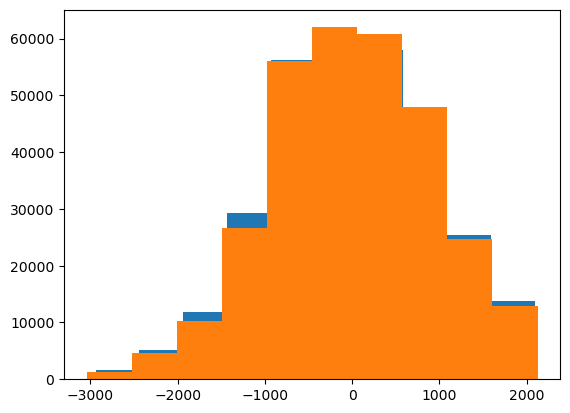

In [94]:
#just showing that pinhole model from open3d and transformation3 model are nearly equal
_=plt.hist(pcd_rgbz_points[:,0])
_=plt.hist(points[:,0])

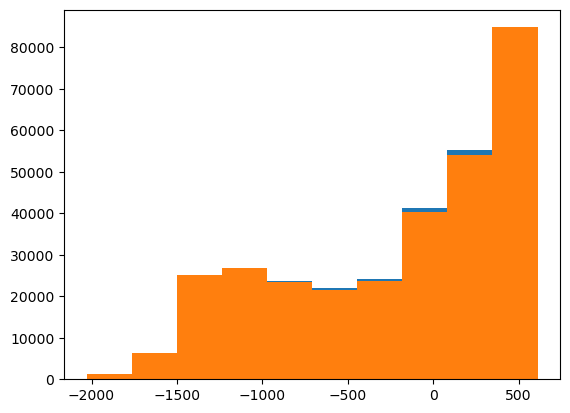

In [95]:
_=plt.hist(points[:,1])
_=plt.hist(pcd_rgbz_points[:,1])


In [52]:
import scipy.linalg as LA
LA.norm(points,2,axis=1)

array([6733., 6733., 6896., ..., 2303., 2311., 2311.])

In [56]:
radialDist[radialDist>0]

array([6733, 6733, 6896, ..., 2303, 2311, 2311], dtype=uint16)

In [57]:
LA.norm(pcd_rgbz_points,2,axis=1)

array([6694.0550987 , 6694.68295764, 6858.4800468 , ..., 2290.5214615 ,
       2298.15399086, 2297.97099017])